In [1]:
%matplotlib inline


# DCGAN with celeba dataset

**Author**: [Solomennikova Julia]


## Introduction

I will train a generative adversarial network (GAN) to generate new
celebrities after showing it pictures of many real celebrities.
## Generative Adversarial Networks

GANs are a framework to capture the data’s distribution. So we can generate new data from that same distribution. 

They are made of two distinct models, a *generator* and a
*discriminator*.  The job of generator - spawn ‘fake’ images liking like the training images. The job of the discriminator - look
at the output and decide whether or not it is a real training image or a
fake one. 


From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}


Although, the convergence theory of GANs is
still under the research and in reality models do not always
train to this way.


DCGAN -  extension of the GAN, but it uses convolutional and convolutional-transpose layers in the discriminator and generator. 

The discriminator is made up of strided Conv2d layers, BatchNorm2d layers, and LeakyReLU activations. The input - 3x64x64 image, the output - scalar probability from the real data distribution.
The generator is comprised of ConvTranspose2d layers, batch norm layers, and ReLU activations. 

In the example, I will setup the optimizers, calculate the loss functions, and initialize the model weights. 



In [12]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 2000
random.seed(manualSeed)
torch.manual_seed(manualSeed)


## Parameters:

-  **workers** - num of threads for DataLoader
-  **batch_size** - batch size (I will use 128 as in paper)
-  **im_size** - size of the images  for train. Defaults is 64x64. 
-  **n_channels** - number of channels in the input 
-  **len_latent** - length of hidden vector
-  **depth_f_gen** - depth of feature maps for generator
-  **depth_f_dis** - depth of feature maps of discriminator
-  **n_epochs** - number of epochs for training. 
-  **lr** - learning rate for trai. According to the DCGAN paper,
   this number is required to be 0.0002
-  **b_1** - beta1 hyperparameter for Adam optim (0.6 as in paper). 
-  **n_gpu** - number of available GPU. 




In [13]:
dataroot = "/datasets/celebA"
workers = 2
batch_size = 128
im_size = 64
n_channels = 3
len_latent = 100
depth_f_gen  = 64
depth_f_dis = 64
n_epochs = 4
lr = 0.0002
b_1 = 0.5
n_gpu = 1

dataset = dset.CelebA(
    root='../datasets/celebA/train_images',
    split='train',
    target_type='identity',
    transform=transforms.Compose([transforms.ToTensor()]),
    download=True)

Files already downloaded and verified


## Data

I will use the [Celeb-A Faces
dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

The dataset will download as a file  **img_celeba.zip**. 





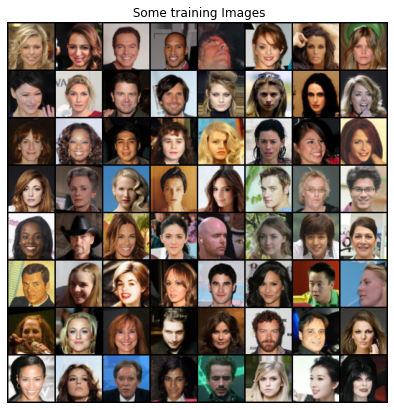

In [14]:
# Create dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(im_size),
                               transforms.CenterCrop(im_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Device to use
device = torch.device("cuda:0" if (torch.cuda.is_available() and n_gpu > 0) else "cpu")

# Plot train images
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title(" Some training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Implementation

I will start with the weight initialization
strategy, then proceed with generator, discriminator, loss functions,
and training loop. 

### Weight Initialization

All model weights should
be  initialized from a Normal distribution with mean=0 and stdev=0.02.

 ``w_init`` function takes model as
input and reinitializes all conv, conv-transpose, and
batch norm layers.




In [15]:
# weights initialization
def w_init(w):
    classname = w.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

### Generator

The generator is designed to map the latent space vector
($z$) to data-space. The output of the generator is contains a tanh func. 


Inputs I set influence the generator architecture in code. 




In [16]:
# Generator 

class Generator(nn.Module):
    def __init__(self, n_gpu):
        super(Generator, self).__init__()
        self.ngpu = n_gpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( len_latent, depth_f_gen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(depth_f_gen * 8),
            nn.ReLU(True),
            # state size. (depth_f_gen*8) x 4 x 4
            nn.ConvTranspose2d(depth_f_gen * 8, depth_f_gen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_f_gen * 4),
            nn.ReLU(True),
            # state size. (depth_f_gen*4) x 8 x 8
            nn.ConvTranspose2d( depth_f_gen * 4, depth_f_gen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_f_gen * 2),
            nn.ReLU(True),
            # state size. (depth_f_gen*2) x 16 x 16
            nn.ConvTranspose2d( depth_f_gen * 2, depth_f_gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_f_gen),
            nn.ReLU(True),
            # state size. (depth_f_gen) x 32 x 32
            nn.ConvTranspose2d( depth_f_gen, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

I can instantiate the generator and apply the ``w_init``




In [17]:
# Create generator
netG = Generator(n_gpu).to(device)

# multi-gpu
if (device.type == 'cuda') and (n_gpu > 1):
    netG = nn.DataParallel(netG, list(range(n_gpu)))

# Apply the w_init func to randomly initialize weights with  mean=0, stdev=0.02.
netG.apply(w_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

Discriminator, $D$, - binary classification
network outputs a scalar probability
that the input image is real. $D$ takes
a 3x64x64 input image, processes and outputs the final probability by a Sigmoid act. function. There is important
to the use of the strided convolution, BatchNorm, LeakyReLU. I will use strided convolution
rather than pooling to downsample. Also batch norm and LeakyReLU propose adequate gradient flow which is vital for the learning  of both
$G$ and $D$.




In [18]:
class Discriminator(nn.Module):
    def __init__(self, n_gpu):
        super(Discriminator, self).__init__()
        self.ngpu = n_gpu
        self.main = nn.Sequential(
            # input is (n_channels) x 64 x 64
            nn.Conv2d(n_channels, depth_f_dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (depth_f_dis) x 32 x 32
            nn.Conv2d(depth_f_dis, depth_f_dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_f_dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (depth_f_dis*2) x 16 x 16
            nn.Conv2d(depth_f_dis * 2, depth_f_dis * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_f_dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (depth_f_dis*4) x 8 x 8
            nn.Conv2d(depth_f_dis * 4, depth_f_dis * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_f_dis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (depth_f_dis*8) x 4 x 4
            nn.Conv2d(depth_f_dis * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

I apply the
``w_init`` function



In [19]:
# Discriminator
netD = Discriminator(n_gpu).to(device)

# multi-gpu 
if (device.type == 'cuda') and (n_gpu > 1):
    netD = nn.DataParallel(netD, list(range(n_gpu)))
    
# Apply the w_init function to initialize all weights with mean=0, stdev=0.2.
netD.apply(w_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss Functions and Optimizers

I will use the Binary Cross
Entropy loss:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

This func provides the calculation of both log components
in the target func ($log(D(x))$ and
$log(1-D(G(z)))$).

Next, I  define real label (1) and the fake label (0). These
labels will be used when calculating the losses
Then, I set 2 optimizers, one for $D$ and
one for $G$.

I will generate a fixed batch
of latent vectors from a Gaussian distribution.




In [20]:
# Init BCELoss
criterion = nn.BCELoss()

# Create batch of latent vectors
fixed_noise = torch.randn(64, len_latent, 1, 1, device=device)

# Establish compromise for real and fake labels 
real_label = 1.
fake_label = 0.

#  Adam optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(b_1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(b_1, 0.999))

### Training

I will construct different mini-batches for real and false
images, and also adjust G target function to maximize
$logD(G(z))$.

 1 - Train the Discriminator 

Goal of training the discriminator - maximize the
probability of correctly classifying a given input as real or false. 
First, I
will construct a batch of real samples from the train set, forward
pass through $D$, calculate the loss then
calculate the gradients. Secondly, I will construct
a batch of false samples with the generator, forward pass and calculate the loss
and accumulate the gradients with a backward. Then, I call for the Discriminator optimizer.

 2 - Train the Generator 

I want to train the Generator by
minimizing $log(1-D(G(z)))$ to generate better falses.

At the end, I do statistic at the end of each
epoch and pull our noise batch through the generator to see the progress of G training.




In [21]:
# Train

# keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training :) ")

for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-false batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, len_latent, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum 
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()


        # maximize log(D(G(z)))
        
        netG.zero_grad()
        label.fill_(real_label) 
        #  another forward pass of all-false batch by D
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Output training statisrics:
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Losses for plot
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        #  how generator is doing on noise
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training :) 
[0/4][0/1583]	Loss_D: 1.7754	Loss_G: 6.2643	D(x): 0.5827	D(G(z)): 0.6222 / 0.0034
[0/4][50/1583]	Loss_D: 0.1279	Loss_G: 9.1954	D(x): 0.9375	D(G(z)): 0.0008 / 0.0004
[0/4][100/1583]	Loss_D: 0.4312	Loss_G: 9.5007	D(x): 0.9285	D(G(z)): 0.2408 / 0.0003
[0/4][150/1583]	Loss_D: 1.5593	Loss_G: 11.8994	D(x): 0.9626	D(G(z)): 0.6995 / 0.0001
[0/4][200/1583]	Loss_D: 1.0838	Loss_G: 3.5184	D(x): 0.5239	D(G(z)): 0.0079 / 0.0491
[0/4][250/1583]	Loss_D: 0.8768	Loss_G: 6.5255	D(x): 0.9375	D(G(z)): 0.4750 / 0.0032
[0/4][300/1583]	Loss_D: 0.7147	Loss_G: 5.8325	D(x): 0.8807	D(G(z)): 0.3857 / 0.0054
[0/4][350/1583]	Loss_D: 0.4764	Loss_G: 3.5234	D(x): 0.8508	D(G(z)): 0.2309 / 0.0487
[0/4][400/1583]	Loss_D: 0.4161	Loss_G: 6.6490	D(x): 0.9043	D(G(z)): 0.2386 / 0.0028
[0/4][450/1583]	Loss_D: 0.9406	Loss_G: 6.3666	D(x): 0.8395	D(G(z)): 0.3735 / 0.0047
[0/4][500/1583]	Loss_D: 0.8364	Loss_G: 8.0173	D(x): 0.9045	D(G(z)): 0.4534 / 0.0007
[0/4][550/1583]	Loss_D: 1.0755	Loss_G: 8.1167	D(x): 0.90

## Results

I see how D and G losses changed
during train. Second, I will visualize G output on thenoise
batch for every epoch.Tthird, I will look at a batch of real data
next to a batch of false data from G.





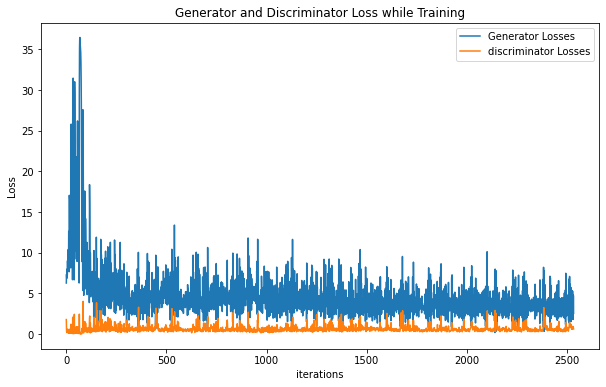

In [22]:
plt.figure(figsize=(10,6))
plt.title("Generator and Discriminator Loss while Training")
plt.plot(G_losses,label="Generator Losses")
plt.plot(D_losses,label="discriminator Losses")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images / False Images**




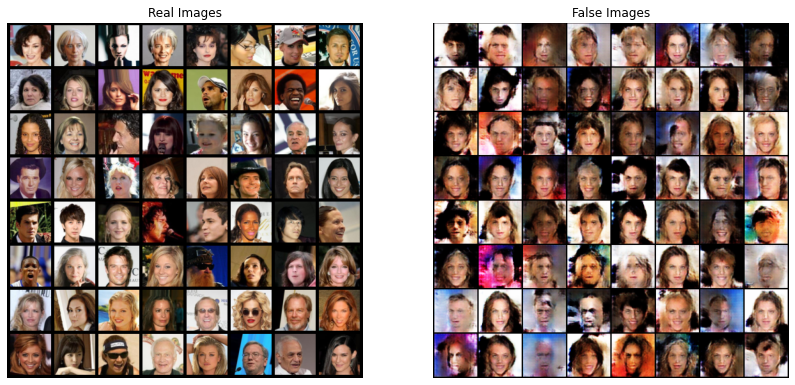

In [24]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# false images from last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("False Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### **CSPNet** - (Cross Stage Partial Networks) - Модифицирует Residual, вместо него вход делится на две части, одна копируется, а другая проходит через блок, потом они конкатенируются и проходят еще свертку 1x1 чтобы перемешаться. 

уменьшет количесто параметров и FLOPS без ухудшения качества. Предыдущая статья тех же авторов (Enriching variety of layer-wise learning information by gradient combination paper) - в которой они предлагают partial ResNet - это когда skip connection только на половину блоков. утверждают что позволяет избавиться от лишних градиентов. Есть интересные картинки про градиенты, которые я пока не поняла :(

CSP вариант уменьшает количество параметров, но остаётся таким же по скорости.